In [ ]:
import warnings



import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords
from typing import Union, Collection
from collections import Counter
import gensim
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic

warnings.filterwarnings("ignore")

In [2]:
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
complaints = pd.read_csv("complaints_2015.csv")
complaints.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
8,2015-09-23,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I recently obtained a mortgage on a parcel of ...,NaN,"Rocket Mortgage, LLC",NY,124XX,NaN,Consent provided,Web,09/23/15,Closed with explanation,Yes,No,1576661
248,2015-09-22,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,Northest Collections Agency XXXX. They have th...,Company believes it acted appropriately as aut...,"Commonwealth Financial Systems, Inc.",NY,XXXXX,NaN,Consent provided,Web,09/22/15,Closed with explanation,Yes,No,1574218
266,2015-10-19,Credit card,NaN,Customer service / Customer relations,NaN,Recently I contacted my credit card Capital On...,NaN,CAPITAL ONE FINANCIAL CORPORATION,NY,10465,NaN,Consent provided,Web,10/19/15,Closed with explanation,Yes,No,1614320
270,2015-06-05,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,Thank you for taking the time to review my inq...,NaN,Ocwen Financial Corporation,NY,11701,NaN,Consent provided,Web,06/09/15,Closed with explanation,Yes,No,1407835
273,2015-08-07,Credit card,NaN,Credit determination,NaN,"On XXXX/XXXX/15, I accepted an invitation on a...",NaN,"Paypal Holdings, Inc",NY,10990,NaN,Consent provided,Web,08/10/15,Closed with explanation,Yes,Yes,1509143


In [4]:
complaints["Date received"] = pd.to_datetime(complaints["Date received"])

In [5]:
nlp = spacy.load("en_core_web_sm", exclude=["ner", "parser"])
stopwords_list = stopwords.words("english")

html_pattern = re.compile(r"<.*?>")
url_pattern = re.compile(r"https?://\S+|www\.\S+")
alphanumeric_pattern = re.compile(r"[^A-Za-z]+")
re_space = re.compile(' {2,}')

emoji_pattern = re.compile(
        "["
        "\U0001f600-\U0001f64f"
        "\U0001f300-\U0001f5ff"
        "\U0001f680-\U0001f6ff"
        "\U0001f1e0-\U0001f1ff"
        "\U00002702-\U000027b0"
        "\U000024c2-\U0001f251"
        "]"
    )

def remove_html_tags(text):
    """
    Removes HTML tags from the input text.

    Args:
        text (str): The input string containing HTML tags.

    Returns:
        str: The text with HTML tags removed.
    """

    return html_pattern.sub(r"", text)


def remove_url(text):
    """
    Removes URLs from the input text.

    Args:
        text (str): The input string that may contain URLs.

    Returns:
        str: The text with URLs removed.
    """
    return url_pattern.sub(r"<url>", text)


exclude = string.punctuation
def remove_punct(text: str):
    """
    Removes punctuation from the input text.

    Args:
        text (str): The input string to process.

    Returns:
        str: The text with punctuation removed.
    """
    return text.translate(str.maketrans("", "", exclude))

def remove_alphanumeric(text:str):
    """
    Removes alphanumeric characters from the input text.

    Args:
        text (str): The input string to process.

    Returns:
        str: The text with alphanumeric characters removed
    """
    return alphanumeric_pattern.sub(r" ", text)

def remove_useless_spaces(t):
    "Remove multiple spaces"
    return re_space.sub(' ', t)


def remove_stopwords(text):
    """
    Removes stopwords from the input text.

    Args:
        text (str): The input string from which stopwords will be removed.

    Returns:
        str: The text with stopwords removed.
    """
    processed_sent = []
    for word in text.split():
        if word not in stopwords_list:
            processed_sent.append(word)
    return " ".join(processed_sent)


def remove_emoji(text):
    """
    Removes emojis from the input text.

    Args:
        text (str): The input string that may contain emojis.

    Returns:
        str: The text with emojis removed.
    """

    return emoji_pattern.sub(r"", text)




def lemmatize_batch(sents, batch_size=100):
    """
    Efficiently lemmatize sentences using batch processing.

    Args:
        sents: List of sentences (either strings or token lists)
        batch_size: Number of sentences to process at once

    Returns:
        List of lemmatized token lists
    """
    # Convert tokenized sentences to strings if needed
    texts = [" ".join(sent) if isinstance(sent, list) else sent for sent in sents]

    # Batch process with nlp.pipe()
    docs = nlp.pipe(texts, batch_size=batch_size)

    # Extract lemmas
    return [[token.lemma_ for token in doc] for doc in docs]


def get_vocab(sents: Union[list[list[str]], list[str]]):
    c = Counter()
    for sent in sents:
        if type(sent) is str:
            for word in sent.split(" "):
                c[word] += 1
        else:
            for word in sent:
                c[word] += 1
    return c

def get_words_with_less_frequency(sents: list[list[str]], min_freq=3):
    vocab = sorted(get_vocab(sents).most_common(), key=lambda x: x[1])
    words_with_min_freq = [v[0] for v in vocab if v[1] <= 3]
    return words_with_min_freq


def preprocess(sents:pd.Series, lemmatize:bool=True) -> list[list[str]]:
    sents = sents.str.lower()
    sents = sents.apply(remove_html_tags)
    sents = sents.apply(remove_url)
    sents = sents.apply(remove_punct)
    sents = sents.apply(remove_useless_spaces)
    sents = sents.apply(remove_stopwords)
    sents = sents.apply(remove_emoji)
    sents = [word_tokenize(sent) for sent in sents]
    if lemmatize:
        sents = lemmatize_batch(sents, batch_size=250)
    return sents


In [6]:
complaints.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [7]:
narratives = complaints["Consumer complaint narrative"]

### Text Cleaning

In [8]:
narratives_tknz_lmtz = preprocess(narratives)
narratives_tknz = preprocess(narratives, lemmatize=False)

In [9]:
less_frequent_words_lmtz = get_words_with_less_frequency(narratives_tknz_lmtz)
less_frequent_words_tknz = get_words_with_less_frequency(narratives_tknz)
vocab_lmtz = get_vocab(narratives_tknz_lmtz)
vocab_tknz = get_vocab(narratives_tknz)
narratives_tknz_lengths = [len(sent) for sent in narratives_tknz]
narratives_tknz_lmtz_lengths = [len(sent) for sent in narratives_tknz_lmtz]


print(f"Mean Narrative Length: {np.mean(narratives_tknz_lengths)}")
print(f"Median Narrative Length: {np.median(narratives_tknz_lengths)}\n")

print("Total Complaints", len(narratives))
print("Total vocab length for lemmatized:", len(vocab_lmtz))
print("Total vocab length for tokenized:", len(vocab_tknz))
print("Less frequency words from lemmatized with minimum frequency of 3:", len(less_frequent_words_lmtz))
print("Less frequency words only tokenized with minimum frequency of 3:", len(less_frequent_words_tknz))

Mean Narrative Length: 91.82134795227346
Median Narrative Length: 66.0

Total Complaints 3101
Total vocab length for lemmatized: 10656
Total vocab length for tokenized: 12916
Less frequency words from lemmatized with minimum frequency of 3: 6843
Less frequency words only tokenized with minimum frequency of 3: 8087


Text(0.5, 9.444444444444438, 'Narrative length')

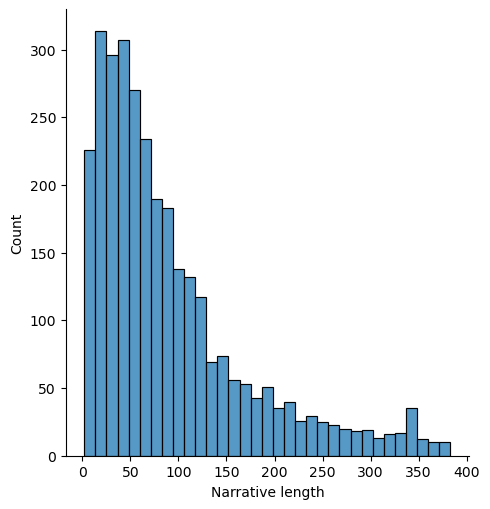

In [10]:
sns.displot([len(sent) for sent in narratives_tknz], kde=False)
plt.xlabel("Narrative length")

Text(0.5, 9.444444444444438, 'Narrative length')

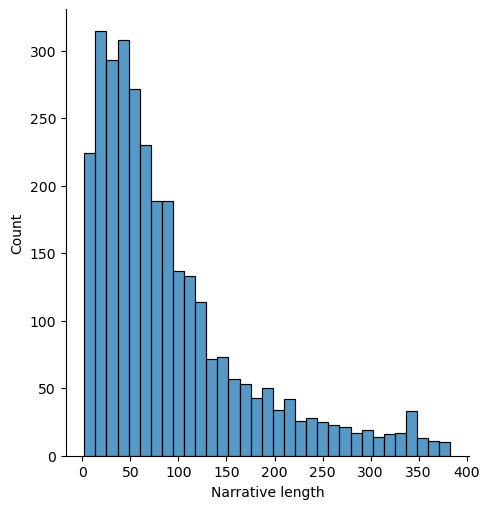

In [11]:
sns.displot([len(sent) for sent in narratives_tknz_lmtz], kde=False)
plt.xlabel("Narrative length")

In [12]:
np.percentile(narratives_tknz_lengths, [2.5, 25, 50, 75, 97.5])

array([  8.,  34.,  66., 120., 329.])

### Vectorization

### 1. TF-IDF

In [13]:
# this will help in ignoring the words that are not widely used thus contributing to dimensionality reduction
tfidf_vect = TfidfVectorizer(stop_words=less_frequent_words_lmtz)

tfidf_vectors = tfidf_vect.fit_transform([" ".join(sent) for sent in narratives_tknz_lmtz])

In [14]:
tfidf_vectors.shape

(3101, 3784)

### 2. Word2Vec

In [15]:
def calc_vocab_similarity(vocab1, vocab2: list[str]):
    common_words = set(vocab1.keys()).intersection(set(vocab2))
    similarity = len(common_words) / len(vocab1)
    total_freq_common = sum([vocab1[word] for word in common_words])
    total_freq = sum(vocab1.values())
    freq_coverage = total_freq_common / total_freq
    print(f"Vocabulary Similarity: {similarity:.4f}")
    print(f"Frequency Coverage: {freq_coverage:.4f}")
    return similarity, freq_coverage

def get_dissimilar_words(vocab1: Collection[str], vocab2: list[str]):
    dissimilar_words = set(vocab1.keys()).difference(set(vocab2))
    return [(word, vocab1[word]) for word in dissimilar_words]

In [16]:
def vectorize_text(text: list[list[str]], embeddings: KeyedVectors, vector_size=300):
    res = np.zeros((len(text), vector_size), dtype=np.float32)
    vocab_set = set(embeddings.index_to_key)
    for idx, sentence in enumerate(text):
        valid_words = [word for word in sentence if word in vocab_set]
        if len(valid_words) > 0:
            res[idx] = np.mean(embeddings[valid_words], axis=0)
    return res

In [17]:
model = gensim.models.Word2Vec(sentences=narratives_tknz, vector_size=300, window=5, min_count=5, workers=8, sg=1, epochs=20)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [18]:
word_vectors = model.wv
word_vectors.save("narratives.wordvectors")

In [19]:
wv = KeyedVectors.load("narratives.wordvectors", mmap='r')

In [20]:
calc_vocab_similarity(vocab_tknz, wv.index_to_key)

Vocabulary Similarity: 0.3274
Frequency Coverage: 0.9513


(0.3274233508826262, 0.951309624988586)

In [21]:
wv.most_similar("loan")

[('20000000', 0.46173030138015747),
 ('countrywide', 0.45004338026046753),
 ('cosigned', 0.4289151728153229),
 ('modifying', 0.4210021495819092),
 ('forgiveness', 0.41677096486091614),
 ('mortgage', 0.4130953252315521),
 ('fay', 0.41165414452552795),
 ('streamline', 0.40706154704093933),
 ('tier', 0.402749627828598),
 ('montage', 0.39989790320396423)]

In [22]:
wv.most_similar("payment")

[('410000', 0.4680652916431427),
 ('interestonly', 0.45695894956588745),
 ('partial', 0.4534350037574768),
 ('9900', 0.45298895239830017),
 ('49000', 0.45048201084136963),
 ('21000', 0.4493556618690491),
 ('310000', 0.4460451304912567),
 ('340000', 0.44466468691825867),
 ('payments', 0.4367457330226898),
 ('230000', 0.43417757749557495)]

In [23]:
wv.most_similar("credit")

[('adversely', 0.5680108666419983),
 ('creditworthiness', 0.5320329666137695),
 ('marks', 0.5259802341461182),
 ('impacting', 0.5212516188621521),
 ('onlythe', 0.5079736113548279),
 ('navy', 0.5061256885528564),
 ('nonmortgage', 0.4998725354671478),
 ('trans', 0.4932788610458374),
 ('deragatory', 0.49070537090301514),
 ('chargedoff', 0.49011871218681335)]

In [24]:
wv.most_similar(wv["loan"] + wv["payment"])

[('loan', 0.7896717190742493),
 ('payment', 0.7611555457115173),
 ('prospect', 0.5151198506355286),
 ('streamline', 0.49673134088516235),
 ('quoted', 0.4942019283771515),
 ('cosigned', 0.49270933866500854),
 ('mohela', 0.49259528517723083),
 ('ins', 0.4849418103694916),
 ('1300000', 0.4831238090991974),
 ('refi', 0.4827793538570404)]

### Topic Modeling

### 1. Latent Dirichlet Allocation

In [25]:
vectorizer = CountVectorizer(stop_words=less_frequent_words_lmtz)

vectors = vectorizer.fit_transform([" ".join(sent) for sent in narratives_tknz_lmtz])
print(vectors.shape)

(3101, 3784)


In [26]:
feature_names = vectorizer.get_feature_names_out()

In [27]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(vectors)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",10
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [28]:
lda.components_.shape

(10, 3784)

In [29]:
doc_topics = lda.transform(vectors)
doc_topics.shape

(3101, 10)

In [30]:
def print_topics(model, n_top_words=10):
    for i, topic in enumerate(model.components_):
        top = topic.argsort()[-n_top_words:][::-1]
        words = [feature_names[j] for j in top]
        print(f"Topic {i}: {', '.join(words)}")

print_topics(lda)

Topic 0: call, not, get, tell, phone, say, time, number, ask, company
Topic 1: xxxx, account, bank, chase, check, charge, fund, deposit, fee, money
Topic 2: xxxx, card, account, call, tell, would, say, not, charge, bank
Topic 3: xxxx, send, letter, pay, receive, call, state, never, 2015, address
Topic 4: xxxx, fargo, credit, wells, year, mortgage, name, never, address, court
Topic 5: xxxx, debt, collection, send, insurance, letter, mortgage, contact, state, company
Topic 6: xxxx, loan, payment, pay, year, rate, month, make, time, student
Topic 7: xxxx, credit, report, account, information, card, dispute, remove, debt, file
Topic 8: xxxx, loan, mortgage, modification, home, document, request, xxxxxxxx, bank, application
Topic 9: payment, pay, fee, month, balance, make, late, interest, charge, amount


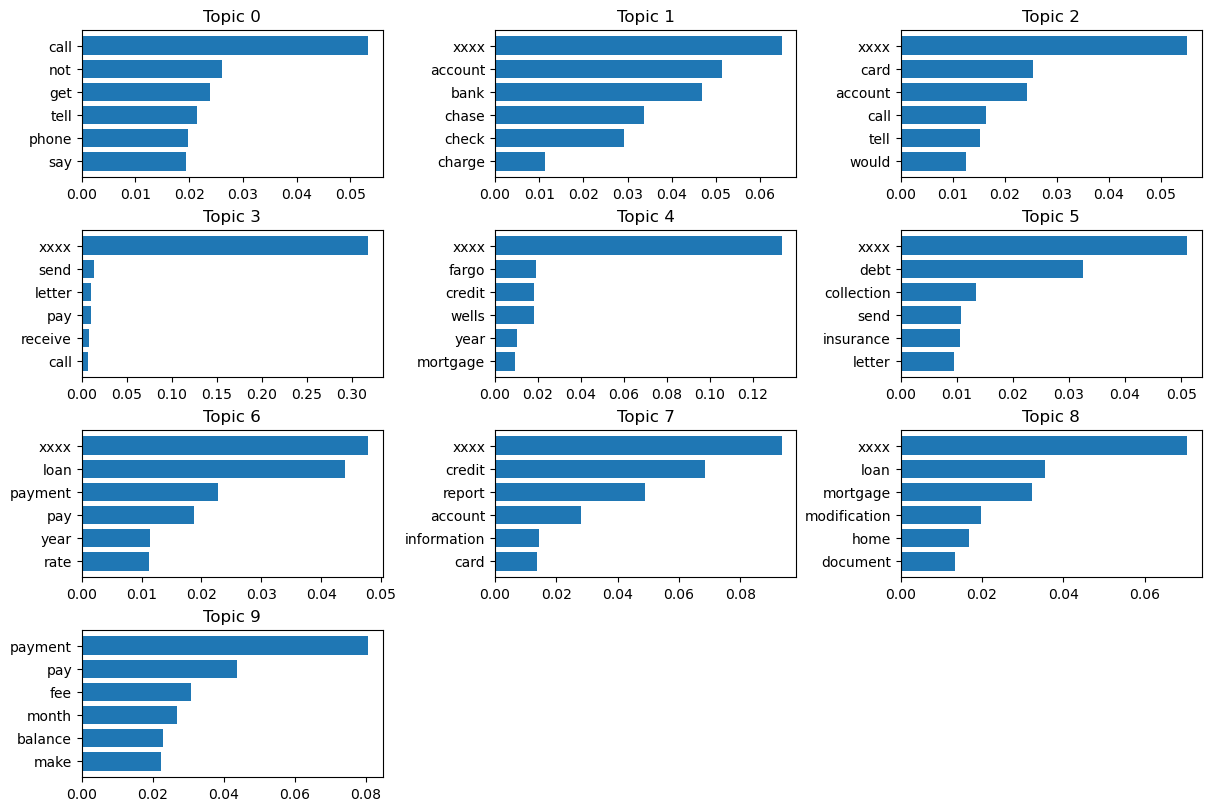

In [31]:
plt.figure(figsize=(12, 8), constrained_layout=True)

def plot_topic_words(model, topic_idx, plot, top_n=10):
    topic = model.components_[topic_idx]
    probs = topic / topic.sum()  # normalize
    top_idx = probs.argsort()[-top_n:][::-1]

    words = [feature_names[i] for i in top_idx]
    values = probs[top_idx]

    plot.barh(words[::-1], values[::-1])
    plot.title(f"Topic {topic_idx}")
    # plot.xlabel("P(word | topic)")


for i in range(1, 11):
  plt.subplot(4, 3, i)
  plot_topic_words(lda, topic_idx=i - 1, plot=plt, top_n=6)
plt.show()

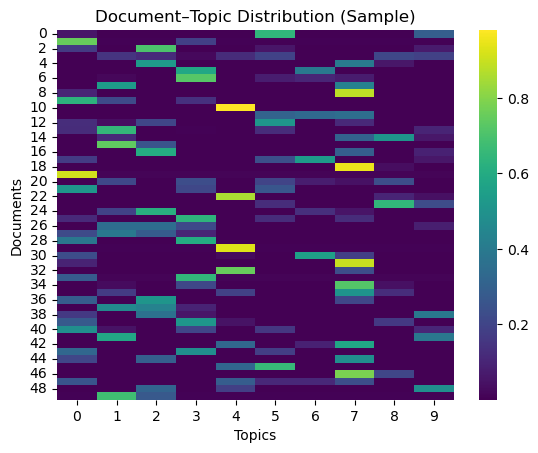

In [32]:
sns.heatmap(
    doc_topics[:50],  # sample docs
    cmap="viridis",
    cbar=True
)
plt.xlabel("Topics")
plt.ylabel("Documents")
plt.title("Document–Topic Distribution (Sample)")
plt.show()

### 2. BERT

In [33]:
model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size=10)
headline_topics, _ = model.fit_transform([" ".join(sent) for sent in narratives_tknz])

2026-02-26 22:11:49,000 - BERTopic - Embedding - Transforming documents to embeddings.
Loading weights: 100%|██████████| 55/55 [00:00<00:00, 1020.86it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L3-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 97/97 [00:15<00:00,  6.27it/s]
2026-02-26 22:12:11,231 - BERTopic - Embedding - Completed ✓
2026-02-26 22:12:11,231 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-26 22:12:32,080 - BERTopic - Dimensionality - Completed ✓
2026-02-26 22:12:32,081 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-26 22:12:32,170 - BERTopic - Cluster - Completed ✓
2026-02-26 22:12:32,1

In [34]:
freq = model.get_topic_info()
print("Number of topics: {}".format(len(freq)))
freq.head()

Number of topics: 49


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1315,-1_xxxx_credit_account_bank,"[xxxx, credit, account, bank, report, would, c...",[complaint caliber home loans bought home xxxx...
1,0,129,0_mortgage_xxxx_loan_property,"[mortgage, xxxx, loan, property, xxxxxxxx, hom...",[modified mortgage xxxx xxxx xxxx xxxx making ...
2,1,126,1_chase_check_bank_account,"[chase, check, bank, account, xxxx, cashed, ca...",[trying use chase card bakery xxxxxxxx15 xxxx ...
3,2,107,2_phone_call_number_calls,"[phone, call, number, calls, calling, stop, ca...",[received phone call last month xxxx xxxx xxxx...
4,3,99,3_loans_student_loan_navient,"[loans, student, loan, navient, payments, priv...",[nearly xxxx student loan debt navient loans o...


In [35]:
a_topic = freq.iloc[1]["Topic"] # Select the 1st topic
model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

[('mortgage', np.float64(0.03486123369309086)),
 ('xxxx', np.float64(0.02862934042255669)),
 ('loan', np.float64(0.016891815728840312)),
 ('property', np.float64(0.01483294380487626)),
 ('xxxxxxxx', np.float64(0.01432106998394267)),
 ('home', np.float64(0.014167561132742429)),
 ('house', np.float64(0.012165590768599657)),
 ('payment', np.float64(0.012076840218414733)),
 ('us', np.float64(0.011178513872666735)),
 ('modification', np.float64(0.01112227325451019))]

In [36]:
model.visualize_barchart(top_n_topics=6)

In [37]:
model.visualize_topics()

In [38]:
model.visualize_hierarchy(top_n_topics=20)

In [39]:
# Select most 3 similar topics
similar_topics, similarity = model.find_topics("mortgage", top_n = 3)

In [40]:
similar_topics

[22, 0, 3]

In [41]:
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('nationstar', np.float64(0.13467323173305162)), ('mortgage', np.float64(0.03684076940795706)), ('modification', np.float64(0.028952943523389795)), ('loan', np.float64(0.022564541449158846)), ('payment', np.float64(0.02215798462188502)), ('documents', np.float64(0.019907913942103964)), ('fee', np.float64(0.018927022817182396)), ('xxxx', np.float64(0.016456350772206765)), ('request', np.float64(0.014986789812034289)), ('month', np.float64(0.014945174522294505))]
Similarity Score: 0.28139203786849976
